# Scenario

The data science team at the CMA have received some complaints from consumers about the number of fake product reviews on a website that sells coffee tables. The complaints allege that coffee table sellers have been trying to mislead consumers by acquiring reviews on their products that do not represent a true customer experience, with the aim of boosting their sales. You have been provided with a dataset of reviews on this website containing the following fields in the `data.parquet` file:

* review_id: the primary key of the dataset, each row of the dataset represents an individual review with a unique identifier
* product_id: an identifier for the coffee table
* reviewer_id: an identifier for the user leaving the review
* review_rating: a score given to the product by the user, out of 5
* review_text: the full text of the review left by the user. This can be blank where the user left a rating only
* review_date: the date the review was posted. The dataset covers the full year to 31 December 2022.

The dataset can be loaded using:
```
import pandas as pd
data = pd.read_parquet("data.parquet")
```
(assuming the data.parquet file is in the same directory as the jupyter notebook)

#### Question 1.

With consideration to the objective of identifying fake reviews, carry out a brief exploratory analysis on the dataset and identify some interesting features. Include a short explanation of any findings.

_Your answer:_

In [304]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_parquet("data.parquet")
data

,review_id,product_id,reviewer_id,review_rating,review_text,review_date
0,1,6,529,5.0,None,2022-01-01
1,2,11,97,5.0,None,2022-01-01
2,3,18,1371,2.0,"2/5 Stars - Subpar. It feels flimsy and cheap,...",2022-01-01
3,4,5,399,5.0,None,2022-01-01
4,5,15,1214,2.0,None,2022-01-01
...,...,...,...,...,...,...
3239,3240,17,2922,5.0,None,2022-12-30
3240,3241,19,1510,5.0,None,2022-12-30
3241,3242,4,2994,1.0,None,2022-12-30
3242,3243,2,2597,4.0,None,2022-12-30


Number of products: 26
Number of reviewers: 2793
Users with the most reviews:
reviewer_id
399     26
902     26
100     26
1496    25
1000    21
95      20
599     20
527     20
784     19
453     19
Name: count, dtype: int64


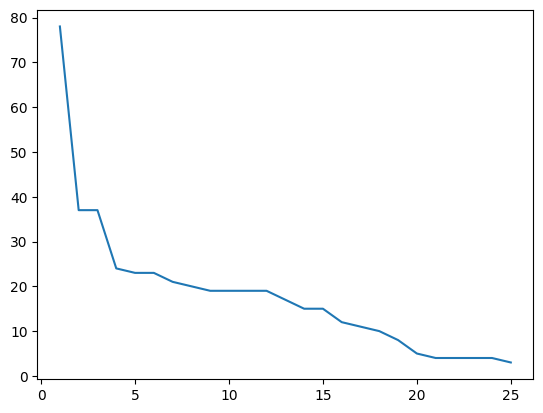

In [305]:
print("Number of products:", len(data["product_id"].unique()))
print("Number of reviewers:", len(data["reviewer_id"].unique()))
user_reviews_count = data["reviewer_id"].value_counts()
print("Users with the most reviews:")
print(user_reviews_count[:10])
user_reviews_count_sum_lst = []
i = 1
user_reviews_count_sum = (data["reviewer_id"].value_counts() > 1).sum()
while user_reviews_count_sum > 0:
    user_reviews_count_sum_lst.append(user_reviews_count_sum)
    i += 1
    user_reviews_count_sum = (data["reviewer_id"].value_counts() > i).sum()
x = np.arange(1, i)
y = np.array(user_reviews_count_sum_lst)
plt.plot(x, y)

The graph above shows the number of users (y-axis) who have written more than x reviews.


With the provided dataset as our sole criteria, we cannot assume that a user with one review has written a fake review. Instead, we should focus on users with multiple reviews. There are 2793 users. Only 78 have more than one review. 

In [306]:
data_review_text = data[~data["review_text"].isnull()]
data_review_text

,review_id,product_id,reviewer_id,review_rating,review_text,review_date
2,3,18,1371,2.0,"2/5 Stars - Subpar. It feels flimsy and cheap,...",2022-01-01
14,15,1,2463,5.0,5/5 Stars - Fantastic.,2022-01-02
38,39,15,2134,5.0,5/5 Stars - Elegant and Functional: I am absol...,2022-01-05
43,44,13,2525,5.0,5/5 Stars - Wow! Modern elegance personified.,2022-01-06
74,75,3,157,5.0,5/5 Stars - Modern Minimalism: I love the mini...,2022-01-11
...,...,...,...,...,...,...
3171,3172,2,2920,1.0,"1/5 Stars - Total Letdown, what a disappointme...",2022-12-18
3187,3188,3,2611,5.0,5/5 Stars - Modern Minimalism: I love the mini...,2022-12-21
3193,3194,21,1376,5.0,5/5 Stars - I adore the simplicity of this pot...,2022-12-22
3195,3196,21,2951,3.0,3/5 Stars - Average Quality: The pot's appeara...,2022-12-23


In [307]:
print("Number of reviews with text:", len(data_review_text))
print("Number of users who have written at least one review:", len((data_review_text["reviewer_id"].unique())))
user_reviews_count[data_review_text["reviewer_id"].unique()]

Number of reviews with text: 293
Number of users who have written at least one review: 293


reviewer_id
1371    1
2463    1
2134    1
2525    1
157     1
       ..
2920    1
2611    1
1376    1
2951    1
1558    1
Name: count, Length: 293, dtype: int64

All reviews with text come from users with only one review. Furthermore, less than 10% of all reviews have text. Given these insights, we can assume that written reviews come from real users and focus on a more significant aspect of the dataset.

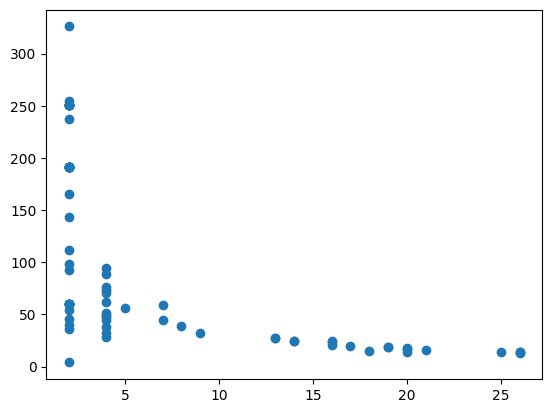

In [308]:
def find_mean_std_time_between_reviews(id, elem):
    diff_lst = []
    prev_date = None
    curr_date = None
    for review in data[data[elem] == id].iterrows():
        if prev_date is None:
            prev_date = review[1]["review_date"]
        else:
            curr_date = review[1]["review_date"]
            diff = (curr_date - prev_date).days
            diff_lst.append(diff)
            prev_date = curr_date
    diff_arr = np.array(diff_lst) if len(diff_lst) > 0 else np.array([365])
    return diff_arr.mean(), diff_arr.std()

mean_times = []
std_times = []
for user_id in user_reviews_count[user_reviews_count > 1].index:
    mean_time, std_time = find_mean_std_time_between_reviews(user_id, "reviewer_id")
    mean_times.append(mean_time)
    std_times.append(std_time)
mean_times = np.array(mean_times)
std_times = np.array(std_times)
x = np.array(user_reviews_count[user_reviews_count > 1])
plt.scatter(x, mean_times)


The graph above shows the mean elapsed time between consecutive reviews on the y-axis and the total number of reviews a user has on the x-axis. We excluded the error bars from the graph as they were not helpful.

As expected, the more reviews a user has, the smaller the mean time between consecutive reviews. If some users are writing fake reviews, they are not writing them in a short period. The potentially fake users may be scattering their reviews over time to avoid arousing suspicion.

We will explore the relationship between reviews and products next.

<ErrorbarContainer object of 3 artists>

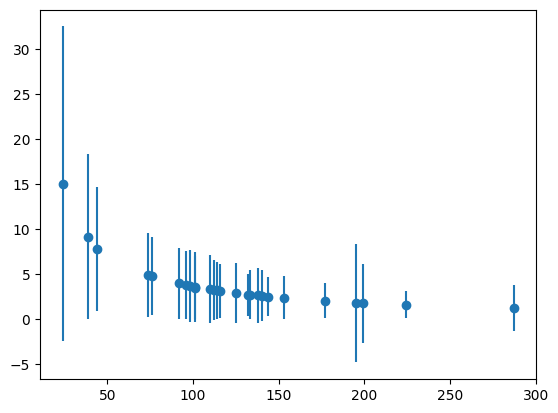

In [309]:
mean_times = []
std_times = []
for product_id in data["product_id"].unique():
    mean_time, std_time = find_mean_std_time_between_reviews(product_id, "product_id")
    mean_times.append(mean_time)
    std_times.append(std_time)
mean_times = pd.Series(mean_times, index=data["product_id"].unique()).reindex(data["product_id"].value_counts().index)
std_times = pd.Series(std_times, index=data["product_id"].unique()).reindex(data["product_id"].value_counts().index)
x = np.array(data["product_id"].value_counts())
plt.errorbar(x, mean_times, yerr=std_times, fmt="o")

The graph above shows the mean elapsed time between consecutive reviews on the y-axis and the total number of reviews a product has on the x-axis.

As expected, the more reviews a product has, the smaller the mean time between consecutive reviews. We can see a natural decrease in the standard deviation of the data points. If products are receiving fake reviews, they are being scattered over time.

The exception to the above comment are products 16, 20, and 5, which have a noticeably higher standard deviation than the adjacent data points.

<ErrorbarContainer object of 3 artists>

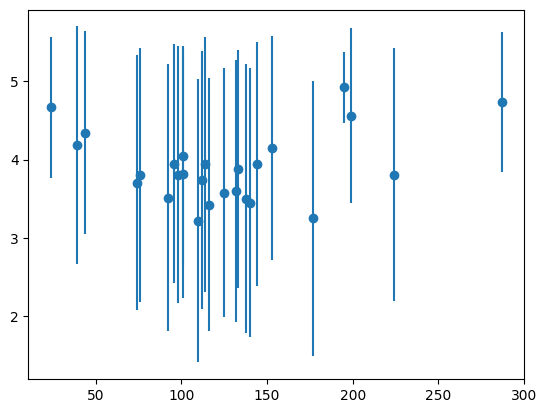

In [310]:
def find_mean_std_review_rating(id, elem):
    ratings = []
    for review in data[data[elem] == id].iterrows():
        ratings.append(review[1]["review_rating"])
    ratings_arr = np.array(ratings)
    return ratings_arr.mean(), ratings_arr.std()

mean_ratings = []
std_ratings = []
for product_id in data["product_id"].unique():
    mean_r, std_r = find_mean_std_review_rating(product_id, "product_id")
    mean_ratings.append(mean_r)
    std_ratings.append(std_r)
mean_ratings = pd.Series(mean_ratings, index=data["product_id"].unique()).reindex(data["product_id"].value_counts().index)
std_ratings = pd.Series(std_ratings, index=data["product_id"].unique()).reindex(data["product_id"].value_counts().index)
x = np.array(data["product_id"].value_counts())
plt.errorbar(x, mean_ratings, yerr=std_ratings, fmt="o")

The graph above shows the average rating of a product on the y-axis and the number of reviews a product has on the x-axis.

We can observe that most products have a similar standard deviation for their rating. However, once again, product 16 is an exception. It has a high rating and a low standard deviation. If we also consider the previous insight, we could suspect that product 16 has a high number of fake reviews.

Another noticeable exceptions are products 20 and 21. However, a smaller number of high-scoring reviews may be causing the lower standard deviation seen in product 21, i.e. the product may be a niche high-quality product.

<ErrorbarContainer object of 3 artists>

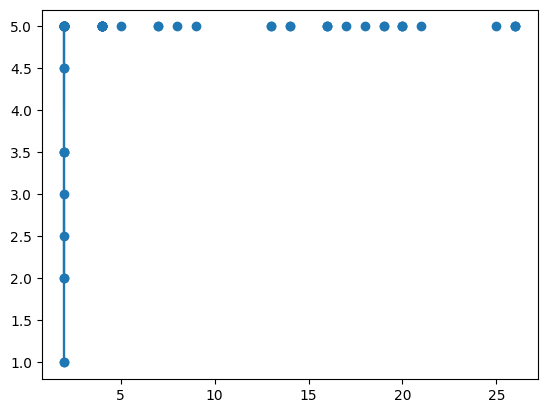

In [311]:
mean_ratings = []
std_ratings = []
for user_id in user_reviews_count[user_reviews_count > 1].index:
    mean_r, std_r = find_mean_std_review_rating(user_id, "reviewer_id")
    mean_ratings.append(mean_r)
    std_ratings.append(std_r)
mean_ratings = np.array(mean_ratings)
std_ratings = np.array(std_ratings)
x = np.array(user_reviews_count[user_reviews_count > 1])
plt.errorbar(x, mean_ratings, yerr=std_ratings, fmt="o")

The graph above shows average review rating (y-axis) for users with x number of reviews.

We can see that all users with more than two reviews have given an average rating of 5.0 with a standard deviation of 0. While there may be a few coffee table enthusiasts, it seems extremely unlikely that the majority of these users are writing authentic reviews.

#### Question 2.

In no more than 500 words, explain how you might develop a system to identify potentially fake reviews in this dataset.

You could consider rule-based methods as well as both supervised and unsupervised machine learning techniques as part of your answer.

_Your answer:_




First, I would implement a rule-based algorithm to flag users with fake reviews. If a user has more than three reviews and a mean rating of 5 with a standard deviation of 0, we identify their reviews as fake. Additionally, if a user has written multiple reviews in quick succession, we would regard their reviews as potentially fake. Similarly, if a product has over 150 reviews, a high mean rating, and a low standard deviation compared to other products, we would flag this product as having received fake reviews and further investigate. We could also consider the mean elapsed time between reviews and the standard deviation.

To use a machine learning model to identify potentially fake reviews, first, we need to transform our data into an appropriate form. We consider five features: product_id, reviewer_id, review_rating, review_text, and review_date. We should also think about whether to examine reviews individually or users. We could also consider products and identify which products have more fake reviews. However, the last approach would not help us to identify the potentially fake reviews.

We could create review vectors by embedding review_text as a 1 or 0, depending on whether the review has text. Since the proportion of reviews with text is small, this is suitable. We could also embed review_date as a day of the year, e.g. 2022-01-03 as 3. This embedding is appropriate as the dataset is limited to one year.

We could also create user vectors by considering the following features for each reviewer: mean rating, standard deviation for the ratings, mean time between consecutive reviews, standard deviation for the time, and whether the user has written a text review. This numerical representation of a reviewer is appropriate as it captures the essential information.

We could use Isolation Forest to detect fake reviews. Isolation Forest is an unsupervised learning algorithm for outlier detection. It uses an ensemble of Isolation Trees to find anomalies in a dataset. Here, we assume that fake reviews are anomalies in the dataset. An Isolation Tree is a decision tree that isolates samples based on randomly selected features and a random split point. The algorithm assigns a value of -1 to outliers and 1 to normal points. It is included in the scikit-learn library and is computationally efficient to implement.

We could combine this method with a clustering algorithm, such as K-means clustering. We would identify different groups in the dataset, potentially identifying a cluster of fake reviews. We would examine each cluster and combine the results from the two previous methods to determine which group contains the fake reviews. Scikit-learn has an implementation of K-means clustering that we could use.

#### Question 3.

Implement one of the methods you have suggested in Question 2 using the dataset. Please provide a brief written explanation of the pros and cons of this method, based on the results you get.

_Your answer:_

In [312]:
from sklearn.ensemble import IsolationForest

data_model = data.copy()
data_model["review_text"] = data["review_text"].apply(lambda x: 0 if x is None else 1)
data_model["review_date"] = data_model["review_date"].apply(lambda x: x.dayofyear)
data_model = data_model.drop(columns=["review_id"])

iso = IsolationForest()
outliers = iso.fit_predict(data_model.to_numpy())
data_model["ISO"] = outliers

In [313]:
print(data_model[data_model["ISO"] == -1])
print(data_model[data_model["ISO"] == -1]["reviewer_id"].value_counts())
print(data_model[data_model["ISO"] == -1]["review_rating"].value_counts())
print(data_model[data_model["ISO"] == -1]["review_text"].value_counts())
print(data_model[data_model["ISO"] == -1]["review_date"].value_counts())

      product_id  reviewer_id  review_rating  review_text  review_date  ISO
0              6          529            5.0            0            1   -1
1             11           97            5.0            0            1   -1
2             18         1371            2.0            1            1   -1
3              5          399            5.0            0            1   -1
4             15         1214            2.0            0            1   -1
...          ...          ...            ...          ...          ...  ...
3237          20           97            5.0            0          363   -1
3238          11         2668            5.0            0          363   -1
3239          17         2922            5.0            0          364   -1
3241           4         2994            1.0            0          364   -1
3242           2         2597            4.0            0          364   -1

[1546 rows x 6 columns]
reviewer_id
100     7
127     6
3       5
97      5
10      4
 

In [314]:
print(user_reviews_count[user_reviews_count > 1])

reviewer_id
399     26
902     26
100     26
1496    25
1000    21
        ..
1010     2
904      2
1484     2
1825     2
52       2
Name: count, Length: 78, dtype: int64


In [315]:
mean_ratings = []
std_ratings = []
mean_times = []
std_times = []
has_text_lst = []
for user_id in data["reviewer_id"].unique():
    mean_r, std_r = find_mean_std_review_rating(user_id, "reviewer_id")
    mean_ratings.append(mean_r)
    std_ratings.append(std_r)
    mean_t, std_t = find_mean_std_time_between_reviews(user_id, "reviewer_id")
    mean_times.append(mean_t)
    std_times.append(std_t)
    has_text = False
    for review in data[data["reviewer_id"] == user_id].iterrows():
        if review[1]["review_text"] is not None:
            has_text = True
    if has_text:
        has_text_lst.append(1)
    else:
        has_text_lst.append(0)
        
data_model = np.array([mean_ratings, std_ratings, mean_times, std_times, has_text_lst]).swapaxes(0, 1)
iso = IsolationForest()
outliers = iso.fit_predict(data_model)
data_model = np.concatenate([data["reviewer_id"].unique().reshape(-1, 1), data_model, outliers.reshape(-1, 1)], axis=1)

In [316]:
output = pd.DataFrame(data_model, columns=["reviewer_id", "mean_r", "std_r", "mean_t", "std_t", "has_text", "ISO"])
print(output[output["ISO"] == -1])
print(output[output["ISO"] == -1]["mean_r"].value_counts())
print(output[output["ISO"] == -1]["std_r"].value_counts())
print(output[output["ISO"] == -1]["mean_t"].value_counts())
print(output[output["ISO"] == -1]["std_t"].value_counts())
print(output[output["ISO"] == -1]["has_text"].value_counts())

      reviewer_id  mean_r  std_r      mean_t     std_t  has_text  ISO
1            97.0     5.0    0.0   24.133333  20.41851       0.0 -1.0
2          1371.0     2.0    0.0  365.000000   0.00000       1.0 -1.0
3           399.0     5.0    0.0   13.520000  15.95273       0.0 -1.0
4          1214.0     2.0    0.0  365.000000   0.00000       0.0 -1.0
5          1335.0     3.0    0.0  365.000000   0.00000       0.0 -1.0
...           ...     ...    ...         ...       ...       ...  ...
2758       2027.0     2.0    0.0  365.000000   0.00000       0.0 -1.0
2772        888.0     3.0    0.0  365.000000   0.00000       0.0 -1.0
2775       1558.0     1.0    0.0  365.000000   0.00000       1.0 -1.0
2779        817.0     2.0    0.0  365.000000   0.00000       0.0 -1.0
2784       1649.0     3.0    0.0  365.000000   0.00000       0.0 -1.0

[702 rows x 7 columns]
mean_r
5.0    215
3.0    192
2.0    176
1.0     92
4.0     21
3.5      3
4.5      2
2.5      1
Name: count, dtype: int64
std_r
0.0    69

### Advantages of Isolation Forest
- It is computationally efficient. It has linear complexity and low memory usage.
- As it is an unsupervised clustering algorithm, it does not need labelled data.
- The algorithm selects users with high mean ratings and low std as outliers. As we discussed in the exploration, it is likely users with many 5-star ratings are likely to be writing fake reviews.

### Disadvantages of Isolation Forest
- We assume that most reviews are real and that fake reviews are outliers, which may not be the case.
- The contamination rate is an important parameter of the Isolation Forest algorithm. It represents the percentage of the dataset that is anomalous. However, we do not know what percentage of the reviews are fake.
- Since reviews/users with text and negative reviews are a small percentage of the dataset, the algorithm regards them as outliers.
- The algorithm does not flag up reviews from users with multiple reviews. Perhaps an additional feature we should consider in the user vector is the number of reviews the user has.